In [1]:
import pandas as pd 
import numpy as np


import os 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# My module built with Spotify API and spotipy library
from spotify import Spotify

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns

# My own credenctials
from utils.config import SpotifyCredectials


Here I want to do EDA(Explanatory Data Analysis) with data which I choose one of the most famous and my favorite rock band "Oasis".<br>


I want to use unsupervised clustering model in upcoming pipeline to categorize their songs so I will work on EDA by keeping that in my mind. 

### Intialize Spotify API with artist Seaching Query

In [2]:
cred = SpotifyCredectials()

my_id = cred.my_id
my_secret = cred.my_secret

spotify = Spotify('Oasis', my_id, my_secret)

### Get all songs df with audio feature

In [3]:
oasis_df = spotify.all_song_feature_df

# Explanatory Data Analysis

### Explore general data information

In [4]:
oasis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 90
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              391 non-null    object 
 1   danceability      391 non-null    float64
 2   energy            391 non-null    float64
 3   key               391 non-null    int64  
 4   loudness          391 non-null    float64
 5   mode              391 non-null    int64  
 6   speechiness       391 non-null    float64
 7   acousticness      391 non-null    float64
 8   instrumentalness  391 non-null    float64
 9   liveness          391 non-null    float64
 10  valence           391 non-null    float64
 11  tempo             391 non-null    float64
 12  type              391 non-null    object 
 13  id                391 non-null    object 
 14  uri               391 non-null    object 
 15  track_href        391 non-null    object 
 16  analysis_url      391 non-null    object 
 17

Observations<br>
<li>it doens't have any missing value. </li>
<li>There are some columns which have dtype as object, so I will check if those are necessary for clustering(Probably not) </li>

In [5]:
cat_cols = oasis_df.select_dtypes(include=['object']).columns.tolist()
cat_df = oasis_df[cat_cols]
cat_df.head(3)

,name,type,id,uri,track_href,analysis_url
0,"Columbia - Live at Knebworth, 10 August '96",audio_features,4GCJnyQmXZG9nBxxTuQ9E4,spotify:track:4GCJnyQmXZG9nBxxTuQ9E4,https://api.spotify.com/v1/tracks/4GCJnyQmXZG9...,https://api.spotify.com/v1/audio-analysis/4GCJ...
1,"Acquiesce - Live at Knebworth, 10 August '96",audio_features,0VAZaVLciiPPfS0onyzRwD,spotify:track:0VAZaVLciiPPfS0onyzRwD,https://api.spotify.com/v1/tracks/0VAZaVLciiPP...,https://api.spotify.com/v1/audio-analysis/0VAZ...
2,"Supersonic - Live at Knebworth, 10 August '96",audio_features,1gzwbFfjM0VR6q9g230SBW,spotify:track:1gzwbFfjM0VR6q9g230SBW,https://api.spotify.com/v1/tracks/1gzwbFfjM0VR...,https://api.spotify.com/v1/audio-analysis/1gzw...


In [6]:
# Check number of unique value in each categorical columns 
cat_unique_df = cat_df.nunique().to_frame().T
print('df size:', len(cat_df))
cat_unique_df

df size: 391


,name,type,id,uri,track_href,analysis_url
0,216,1,391,391,391,391


Observations<br>
<li>'type' has only one value, so we it's not necessary.</li>
<li>'id', 'uri', 'track_href', 'analysis_url' are all unique and these columns are identical information, so those are also not necessary.</li>
<li>'name' was not all unique, which means some tracks are duplicated. I will investigate it more to learn audio feature for those duplicates are also duplicated</li>

In [7]:
# Drop unnecessary categorical columns 
oasis_df = oasis_df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url'], axis=1)

### Handle Duplicated tracks

In [8]:
# Get duplicated tracks and counts
track_count_df = oasis_df['name'].value_counts().to_frame().reset_index()
track_count_df_duplicates = track_count_df[track_count_df['name']>1]
track_count_df_duplicates.head(5)

,index,name
0,Falling Down,9
1,I'm Outta Time,9
2,The Shock Of The Lightning,9
3,The Turning,7
4,Soldier On,7


Observations<br>
<li>It seems like track can be duplicated up to 9 in the case of Oasis</li>
<li>Let's take a look 'Falling Down' and how values are diffrent.</li>

In [9]:
falling_down_df = oasis_df[oasis_df['name']=='Falling Down'].reset_index(drop=True)
falling_down_df

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Falling Down,0.437,0.964,6,-3.031,0,0.0597,0.00103,0.0733,0.149,0.236,130.963,260080,4
1,Falling Down,0.445,0.960,1,-3.270,0,0.0698,0.00118,0.1380,0.336,0.182,130.968,267587,4
2,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4
3,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4
4,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4
5,Falling Down,0.437,0.964,6,-3.031,0,0.0597,0.00103,0.0733,0.149,0.236,130.963,260080,4
6,Falling Down,0.442,0.965,6,-3.003,0,0.0598,0.00107,0.1070,0.146,0.252,130.961,260080,4
7,Falling Down,0.442,0.965,6,-3.003,0,0.0598,0.00107,0.1070,0.146,0.252,130.961,260080,4
8,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4


Observations<br>
<li>It seems audio values are different amongs those songs.</li>
<li>Most of the tracks should have similar values. I will see it more</li>

In [10]:
def standard_scaling(data):
    scaler = StandardScaler()
    scaler.fit(data)
    scaled_df = pd.DataFrame(scaler.transform(data))

    return scaled_df

# Scaling values and see value distribution among those duplicated tracks.
data = falling_down_df[falling_down_df.columns[1:]]
scaled_df = standard_scaling(data)
scaled_df.columns = falling_down_df.columns[1:]

scaled_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-1.609947,-0.143592,0.353553,0.095616,0.0,-0.393306,-0.801486,-1.616697,-0.315656,-0.232513,0.589256,-0.353553,0.0
1,1.799352,-2.728241,-2.828427,-2.801149,0.0,2.827548,2.688856,1.858396,2.827828,-2.689065,2.357023,2.828427,0.0
2,0.094703,0.502571,0.353553,0.434986,0.0,-0.329526,-0.336107,0.247070,-0.366086,0.540846,-0.824958,-0.353553,0.0
3,0.094703,0.502571,0.353553,0.434986,0.0,-0.329526,-0.336107,0.247070,-0.366086,0.540846,-0.824958,-0.353553,0.0
4,0.094703,0.502571,0.353553,0.434986,0.0,-0.329526,-0.336107,0.247070,-0.366086,0.540846,-0.824958,-0.353553,0.0
5,-1.609947,-0.143592,0.353553,0.095616,0.0,-0.393306,-0.801486,-1.616697,-0.315656,-0.232513,0.589256,-0.353553,0.0
6,0.520865,0.502571,0.353553,0.434986,0.0,-0.361416,0.129272,0.193359,-0.366086,0.495354,-0.117851,-0.353553,0.0
7,0.520865,0.502571,0.353553,0.434986,0.0,-0.361416,0.129272,0.193359,-0.366086,0.495354,-0.117851,-0.353553,0.0
8,0.094703,0.502571,0.353553,0.434986,0.0,-0.329526,-0.336107,0.247070,-0.366086,0.540846,-0.824958,-0.353553,0.0


<AxesSubplot:>

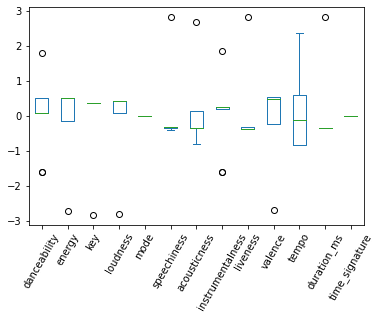

In [11]:
scaled_df.plot(kind='box',rot=60)

Observations<br>
<li>It seems audio values almost fall into within 1 from standard deviation after scaled values.</li>
<li>But we can also observe one outlier in all columns. I guess this outlier is same track but it's recorded in different time such as version remasetered or concert etc. </li>
<li>I want to remove this outlier because it will affect when I want to use mean value among those duplicated tracks to representation feature values of this specific song. 


Approach of removing outlier<br>
<li>Remove entry if the entry has more than 50 % of columns which are not between -1 and 1 after it's standardized</li>


In [12]:
def check_outlier(row, threshold):
    n_outliers = len([value for value in row.values if abs(value)>1 ])

    if n_outliers > threshold:
        return False
    else:
        return True

# Define Threshold 
threshold = len(scaled_df.columns)/2

# Get index of non-outlier tracks
non_outlier_index = scaled_df.apply(lambda x: check_outlier(x, threshold), axis=1)

cleaned_scaled_df = scaled_df[non_outlier_index]
cleaned_falling_down_df = falling_down_df[non_outlier_index]
cleaned_falling_down_df

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Falling Down,0.437,0.964,6,-3.031,0,0.0597,0.00103,0.0733,0.149,0.236,130.963,260080,4
2,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4
3,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4
4,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4
5,Falling Down,0.437,0.964,6,-3.031,0,0.0597,0.00103,0.0733,0.149,0.236,130.963,260080,4
6,Falling Down,0.442,0.965,6,-3.003,0,0.0598,0.00107,0.1070,0.146,0.252,130.961,260080,4
7,Falling Down,0.442,0.965,6,-3.003,0,0.0598,0.00107,0.1070,0.146,0.252,130.961,260080,4
8,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4


In [13]:
# Check dropped row 
dropped_falling_down_df = falling_down_df[~falling_down_df.isin(cleaned_falling_down_df)].dropna()
dropped_falling_down_df

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
1,Falling Down,0.445,0.96,1.0,-3.27,0.0,0.0698,0.00118,0.138,0.336,0.182,130.968,267587.0,4.0


Observations<br>
<li>We have found one entry is dropped</li>
<li>I will see it more by comparing mean value of all entries except for outlier and dropped row.</li>

In [14]:
# Compare two data aggregated clean falling_down_df and removed falling_down_df

# Aggregate cleaned_df with average
agg_cleaned_falling_down_df = cleaned_falling_down_df.groupby(['name']).mean().reset_index()

# Add new column to distinguish two rows 
agg_cleaned_falling_down_df.insert(1, 'data', ['cleaned'])
dropped_falling_down_df.insert(1, 'data', ['removed'])

compare_df = pd.concat([agg_cleaned_falling_down_df,dropped_falling_down_df ])
compare_df


,name,data,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Falling Down,cleaned,0.44025,0.96475,6.0,-3.01,0.0,0.059825,0.00105,0.099075,0.14675,0.2485,130.9605,260080.0,4.0
1,Falling Down,removed,0.44500,0.96000,1.0,-3.27,0.0,0.069800,0.00118,0.138000,0.33600,0.1820,130.9680,267587.0,4.0


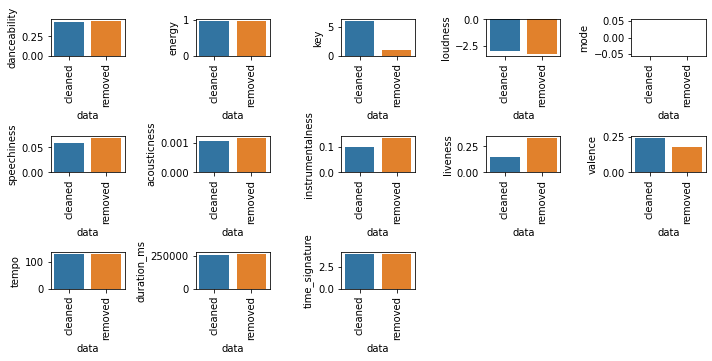

In [15]:
#Plot for comparison
plt.figure(figsize=(10, 5))
for i, c in enumerate(compare_df.columns[2:], 1):
    plt.subplot(3, 5,i)
    plt.tight_layout()
    plt.xticks(rotation = 90)
    sns.barplot(x = 'data', y = compare_df[c], data =compare_df)

Observations<br>
<li>We can observe values in some columns are actually different even those are supposed to be same tracks and should have same figures such as 'key', 'liveness', 'insstrumentalness', 'valence'</li>

Summarize of Handle Duplicated tracks<br>
<li>There are duplicated tracks and audio feature values among those. Values are slightly different and sometimes it has outlier value which I assume recorded at different time.</li>
<li>I removed outlier by seeing its standarized value and if more than 50% column values are not between -1 and 1</li>
<li>I will apply this method for all all duplicated tracks in pipeline as part of preprocess</li>

In [16]:
# Create function. Later I can put this to pipeline.

def remove_outlier(track_df):
    track_df = track_df.reset_index(drop = True)
    # Scaling values and see value distribution among those duplicated tracks.
    data = track_df[track_df.columns[1:]]
    scaled_df = standard_scaling(data)
    scaled_df.columns = track_df.columns[1:]

    # Define Threshold 
    threshold = len(scaled_df.columns)/2

    # Get index of non-outlier tracks
    non_outlier_index = scaled_df.apply(lambda x: check_outlier(x, threshold), axis=1)

    cleaned_track_df = track_df[non_outlier_index]
    cleaned_track_df = cleaned_track_df.groupby(['name']).mean().reset_index()

    return cleaned_track_df

def duplicated_tracks_handler_wrapper(original_artist_df):

    artist_df = original_artist_df.copy()

    # Get duplicated tracks and counts
    track_count_df = artist_df['name'].value_counts().to_frame().reset_index()
    track_count_df_duplicates = track_count_df[track_count_df['name']>1]
    duplicated_tracks = list(track_count_df_duplicates['index'].unique())
    

    # Separate original df into non_duplicated_tracks and duplicated_tracks df
    not_duplcated_tracks_df = artist_df[~artist_df['name'].isin(duplicated_tracks)]
    
    duplicated_tracks_df = artist_df[artist_df['name'].isin(duplicated_tracks)]

    # For duplicated track, it will remove outlier 
    duplicated_tracks_df_removed_outlier = duplicated_tracks_df.groupby(['name']).apply(lambda x:remove_outlier(x))

    # Re-merge two dataframe to make it original 
    cleaned_df = pd.concat([not_duplcated_tracks_df, duplicated_tracks_df_removed_outlier]).reset_index(drop = True)

    return cleaned_df

    

In [17]:
# Now we get dataframe with only unique tracks.

unique_artist_df = duplicated_tracks_handler_wrapper(oasis_df)
unique_artist_df.head()

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,"Columbia (Live at Knebworth, 10 August '96)",0.275,0.806,2.0,-4.956,1.0,0.0442,0.000018,0.824,0.979,0.196,99.911,287722.0,4.0
1,"Acquiesce (Live at Knebworth, 10 August '96)",0.260,0.926,7.0,-4.668,1.0,0.0619,0.000009,0.884,0.982,0.253,124.697,236778.0,4.0
2,"Supersonic (Live at Knebworth, 10 August '96)",0.258,0.928,9.0,-4.918,1.0,0.0941,0.000049,0.489,0.985,0.422,122.963,309880.0,4.0
3,"Hello (Live at Knebworth, 11 August '96)",0.119,0.962,5.0,-4.118,1.0,0.0842,0.000018,0.589,0.856,0.150,149.610,175536.0,4.0
4,"Some Might Say (Live at Knebworth, 11 August '96)",0.168,0.869,2.0,-4.122,1.0,0.0736,0.000009,0.458,0.921,0.177,123.259,304629.0,4.0


### Correlations among features<br>
You can check features detail from here: <br>
https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

<AxesSubplot:>

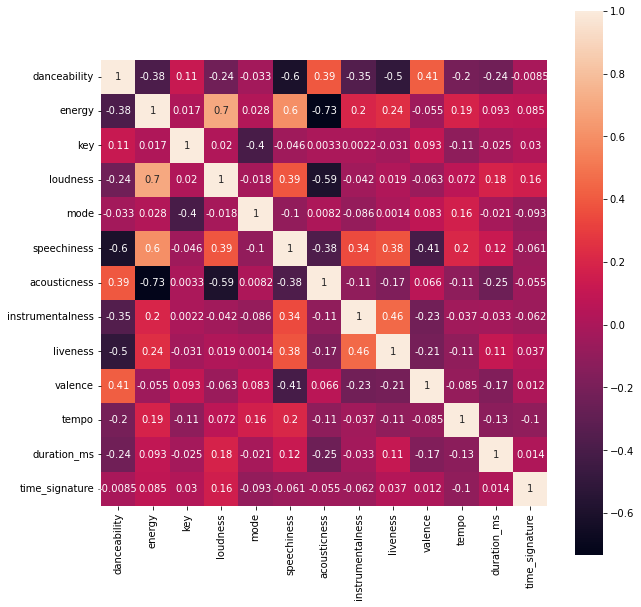

In [18]:
# Let's see the correlations among features in oasis tracks
corr_info_df = unique_artist_df.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corr_info_df, square=True, annot=True)

In [70]:
# Let's extract only combinations with high correlations

def get_high_corr_information(corr_info_df, value_threshold_high= 0.5, value_threshold_med= 0.4):
    corr_info_df = corr_info_df.copy()
    
    value_list = []
    rows = []
    for col in corr_info_df.columns:
        for value, vs_col in zip(corr_info_df[col], corr_info_df.columns):
            if (abs(value)>=value_threshold_med)&(value!=1)&(not value in value_list):
                if abs(value)>=value_threshold_high:
                    corr_label = 'high'

                elif value_threshold_high>abs(value)>=value_threshold_med:
                    corr_label = 'medium'

                if value>0:
                    direction = 'positive'
                else:
                    direction = 'negative'

                row = {'col_1': col ,'col_2': vs_col, 'value': value, 'direction':direction,'corr_label':corr_label}
                rows.append(row)
                value_list.append(value)

    high_corr_df = pd.DataFrame(rows)
    positive_corr_df = high_corr_df[high_corr_df['direction']=='positive'].sort_values(by = ['value'], ascending=False)
    negative_corr_df = high_corr_df[high_corr_df['direction']=='negative'].sort_values(by = ['value'], ascending=True)
    
    return positive_corr_df, negative_corr_df

In [71]:
positive_corr_df, negative_corr_df = get_high_corr_information(corr_info_df)

In [72]:
positive_corr_df

,col_1,col_2,value,direction,corr_label
3,energy,loudness,0.695749,positive,high
4,energy,speechiness,0.597442,positive,high
9,instrumentalness,liveness,0.456082,positive,medium
2,danceability,valence,0.414912,positive,medium


Observations<br>
<li>[energy - loudness]-> Make sense</li>
<li>[energy - speechiness] -> I learned Spotify is more likely to consider energy like speechiness</li>
<li>[instrumentalness - liveness] -> I learned Spotify is more likely to consider live audio like instumentalness</li>
<li>[danceability - valence] -> I learned Spotify is more likely to consider danceability as valence</li>

In [74]:
negative_corr_df

,col_1,col_2,value,direction,corr_label
5,energy,acousticness,-0.732292,negative,high
0,danceability,speechiness,-0.603883,negative,high
7,loudness,acousticness,-0.592019,negative,high
1,danceability,liveness,-0.503725,negative,high
8,speechiness,valence,-0.413040,negative,medium
6,key,mode,-0.403803,negative,medium


Observations<br>
<li>[energy - acousticness], [energy - speechiness], [loudness - acousticness] -> Make sense</li>
<li>[danceability - liveness] -> I learned Spotify is more likely to consider danceability as non-liveness. It's somehow making sense if see the high correlations between liveness and instrumentalness</li>
<li>[speechiness - valence] -> I learned Spotify is more likely not to consider speechiness  as valence</li>
<li>[key - mode] -> I learned Spotify is more likely not to consider key  as mode</li>

Observations<br>
<li>We can observe values in some columns are actually different even those are supposed to be same tracks and should have same figures such as 'key', 'liveness', 'insstrumentalness', 'valence'</li>

### See top 5 and bottom 5 songs by each feature

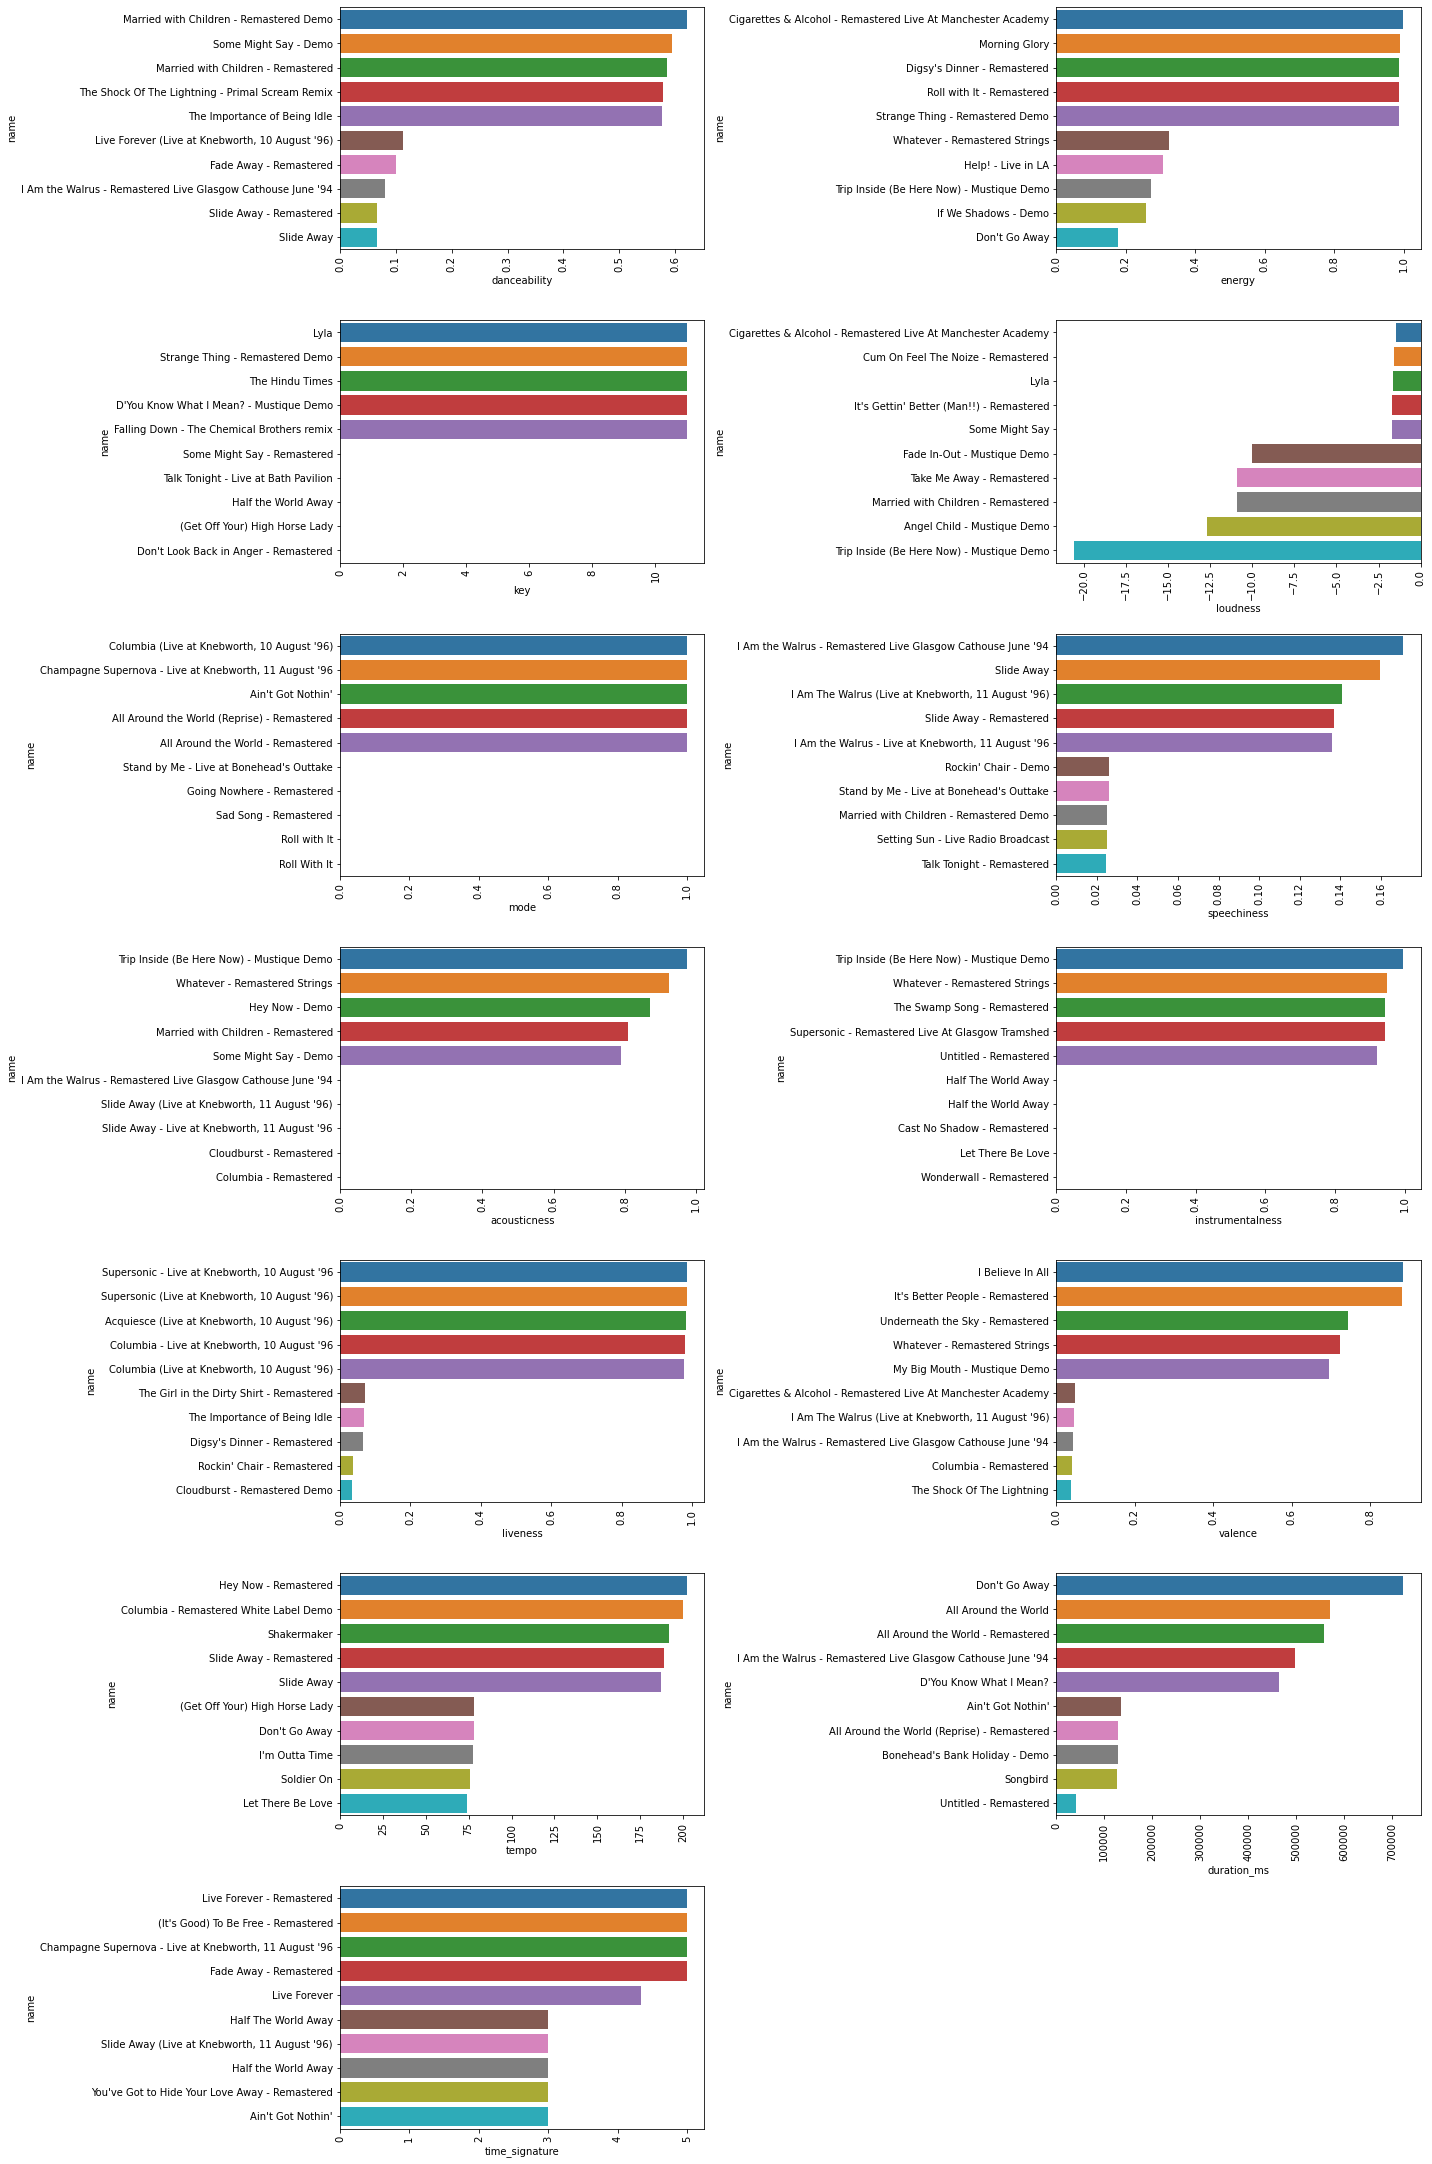

In [109]:
#Plot for comparison
plt.figure(figsize=(20, 30))
for i, c in enumerate(unique_artist_df.columns[1:], 1):
    col_df = unique_artist_df[['name', c]].sort_values(by = [c], ascending=False)
    head_df = col_df.head(5)
    tail_df = col_df.tail(5)
    rank_df = pd.concat([head_df, tail_df])
    
    plt.subplot(7, 2,i)
    plt.tight_layout()
    plt.xticks(rotation = 90)
    sns.barplot(x = c, y = 'name', data =rank_df)
